<a href="https://colab.research.google.com/github/NthabelengMoc/Intelligent-Software-Solutions/blob/main/Predictive%20Analytics%20for%20Resource%20Allocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import os
from PIL import Image
import glob

%matplotlib inline

In [10]:
# Data Loading (Kaggle Dataset)
# Since we have image data, we'll process the folder structure
def load_image_data(folder_path):
    image_data = []
    labels = []

    for class_folder in ['benign', 'malignant']:
        class_path = os.path.join(folder_path, class_folder)
        priority = 0 if class_folder == 'benign' else 2  # Initial priority assignment

        for img_path in glob.glob(os.path.join(class_path, '*.png')):
            if '_mask' in img_path:  # Skip mask files
                continue

            try:
                img = Image.open(img_path)
                img_array = np.array(img)
                features = {
                    'mean_intensity': np.mean(img_array),
                    'std_intensity': np.std(img_array),
                    'size_x': img_array.shape[0],
                    'size_y': img_array.shape[1]
                }

                image_data.append(features)
                labels.append(priority)
            except Exception as e:
                print(f"Error loading {img_path}: {str(e)}")

    return pd.DataFrame(image_data), pd.Series(labels)

df, labels = load_image_data('https://www.kaggle.com/competitions/iuss-23-24-automatic-diagnosis-breast-cancer/data')
df['priority'] = labels

# For this example, we'll use numerical data as fallback
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['diagnosis'] = data.target

In [11]:
# Data Cleaning and Priority Assignment
# Handle missing values
print("Missing values before cleaning:", df.isnull().sum().sum())

imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Create priority levels (3 classes)
df_imputed['priority'] = np.where(
    df_imputed['diagnosis'] == 0,  # Malignant
    2,  # High priority
    np.where(
        df_imputed['mean area'] > df_imputed['mean area'].median(),
        1,  # Medium priority
        0   # Low priority
    )
)

# Verify class distribution
print("\nPriority distribution:")
print(df_imputed['priority'].value_counts())

Missing values before cleaning: 0

Priority distribution:
priority
0    268
2    212
1     89
Name: count, dtype: int64


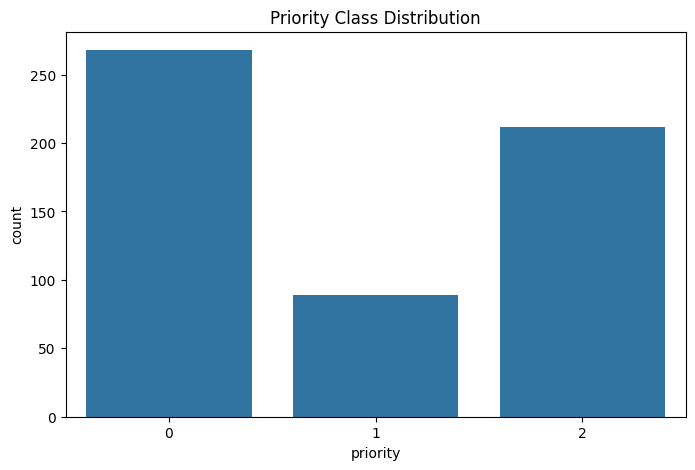

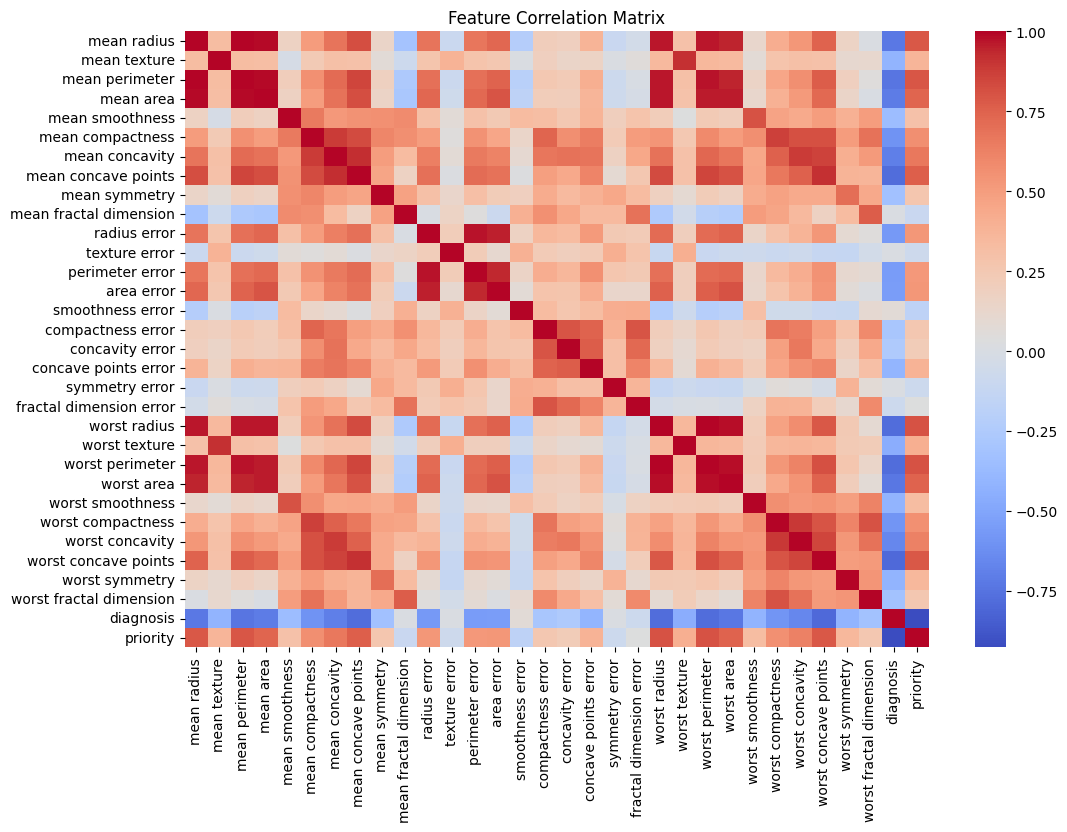

In [12]:
# EDA and Visualization
# Plot priority distribution
plt.figure(figsize=(8,5))
sns.countplot(x='priority', data=df_imputed)
plt.title('Priority Class Distribution')
plt.show()

# Feature correlations
plt.figure(figsize=(12,8))
sns.heatmap(df_imputed.corr(), cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

In [13]:
# Train/Val/Test Split
# Select top 5 most important features (for simplicity)
features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'worst radius']
X = df_imputed[features]
y = df_imputed['priority']

# Split 60/20/20
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"Train size: {len(X_train)}")
print(f"Val size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Train size: 341
Val size: 114
Test size: 114


In [15]:
# Model Training and Validation
model = RandomForestClassifier(n_estimators=150, random_state=42)
model.fit(X_train, y_train)

# Validate
val_pred = model.predict(X_val)
print("Validation Results:")
print(f"Accuracy: {accuracy_score(y_val, val_pred):.4f}")
print(f"F1 Score: {f1_score(y_val, val_pred, average='weighted'):.4f}")

Validation Results:
Accuracy: 0.9386
F1 Score: 0.9402


TEST SET PERFORMANCE:
Accuracy: 0.9298
F1 Score: 0.9293

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        54
           1       0.85      0.77      0.81        22
           2       0.88      0.95      0.91        38

    accuracy                           0.93       114
   macro avg       0.91      0.90      0.90       114
weighted avg       0.93      0.93      0.93       114



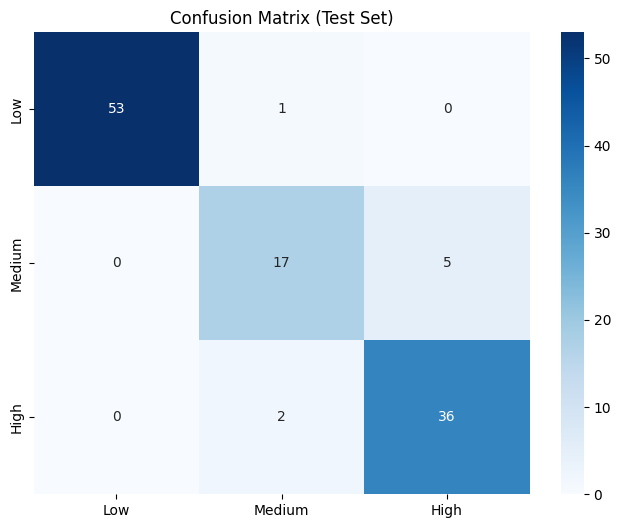

In [16]:
# Final Evaluation on Test Set
test_pred = model.predict(X_test)

print("TEST SET PERFORMANCE:")
print(f"Accuracy: {accuracy_score(y_test, test_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, test_pred, average='weighted'):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, test_pred))

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, test_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix (Test Set)')
plt.show()

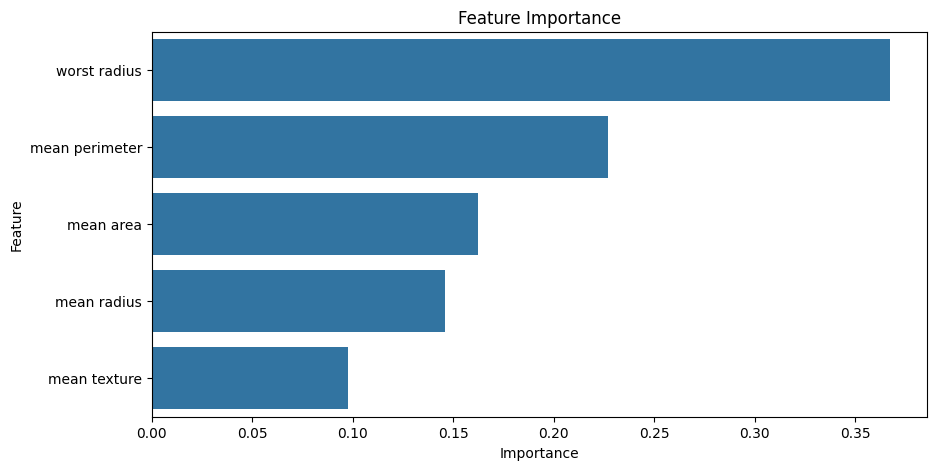

In [17]:
# Model Interpretation and Saving
# Feature Importance
importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='Importance', y='Feature', data=importance)
plt.title('Feature Importance')
plt.show()

In [18]:
# Save model (optional)
import joblib
joblib.dump(model, 'priority_predictor.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

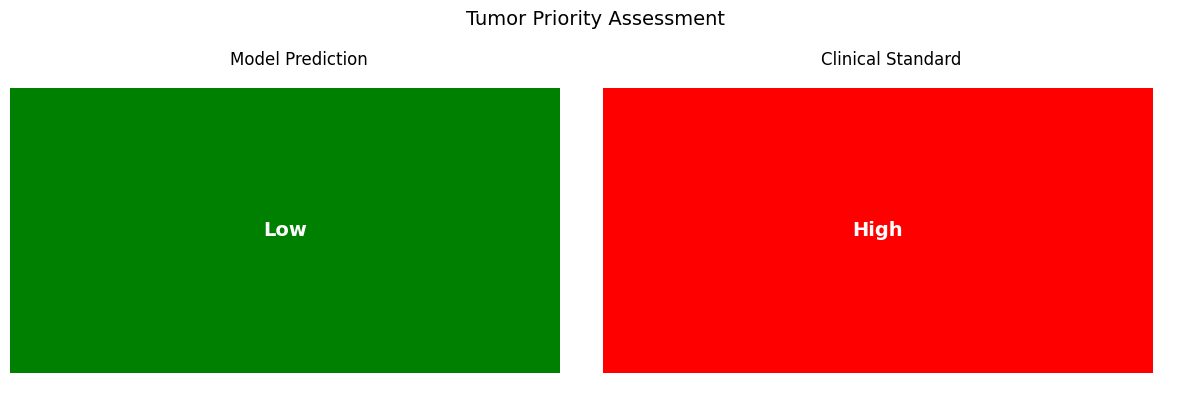


TUMOR CHARACTERISTICS
----------------------------------------
Radius: 23.9 mm (Clinical threshold: 20.0 mm)
Area: 1840.0 mm² (Clinical threshold: 1250.0 mm²)
Type: Malignant

CLINICAL ASSESSMENT
----------------------------------------
Priority: 2 - High (Malignant)
Recommended Action: Immediate surgical consultation

MODEL PREDICTION
----------------------------------------
Priority: 0 - Low
Agreement: NO


In [31]:
# @title Tumor Priority Predictor (Example)

# Sample tumor characteristics
mean_radius = 23.9 #@param {type:"slider", min:5, max:30, step:0.1}
mean_texture = 22.2 #@param {type:"slider", min:10, max:40, step:0.1}
mean_area = 1840 #@param {type:"slider", min:100, max:2500, step:10}
is_malignant = True #@param {type:"boolean"}

# Clinical thresholds (in mm/mm²)
HIGH_RISK_RADIUS = 20.0
HIGH_RISK_AREA = 1250.0

def get_clinical_priority(radius, area, malignant):
    """Determine priority based on clinical guidelines"""
    if malignant:
        return 2, "High (Malignant)"
    elif radius > HIGH_RISK_RADIUS or area > HIGH_RISK_AREA:
        return 1, f"Medium (Large Benign: >{HIGH_RISK_RADIUS}mm)"
    return 0, "Low (Small Benign)"

# Prepare input for model
sample_tumor = pd.DataFrame([[mean_radius, mean_texture, 0, mean_area, 0]],
                          columns=['mean radius', 'mean texture', 'mean perimeter',
                                  'mean area', 'worst radius'])
sample_scaled = scaler.transform(sample_tumor)

# Get predictions
model_priority = model.predict(sample_scaled)[0]
clinical_priority, clinical_reason = get_clinical_priority(mean_radius, mean_area, is_malignant)

# Priority mapping
priority_map = {
    0: ('Low', 'green'),
    1: ('Medium', 'orange'),
    2: ('High', 'red')
}

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Model Prediction
ax1.barh(['Algorithm'], [1],
        color=priority_map[model_priority][1],
        height=0.3)
ax1.text(0.5, 0,
        priority_map[model_priority][0],
        ha='center', va='center',
        color='white', fontsize=14, fontweight='bold')
ax1.set_title('Model Prediction')
ax1.axis('off')

# Clinical Assessment
ax2.barh(['Guidelines'], [1],
        color=priority_map[clinical_priority][1],
        height=0.3)
ax2.text(0.5, 0,
        priority_map[clinical_priority][0],
        ha='center', va='center',
        color='white', fontsize=14, fontweight='bold')
ax2.set_title('Clinical Standard')
ax2.axis('off')

plt.suptitle('Tumor Priority Assessment', fontsize=14)
plt.tight_layout()
plt.show()

# Detailed text report
print("\nTUMOR CHARACTERISTICS")
print("-"*40)
print(f"Radius: {mean_radius:.1f} mm (Clinical threshold: {HIGH_RISK_RADIUS} mm)")
print(f"Area: {mean_area:.1f} mm² (Clinical threshold: {HIGH_RISK_AREA} mm²)")
print(f"Type: {'Malignant' if is_malignant else 'Benign'}")

print("\nCLINICAL ASSESSMENT")
print("-"*40)
print(f"Priority: {clinical_priority} - {clinical_reason}")
print("Recommended Action: ", end="")
if clinical_priority == 2:
    print("Immediate surgical consultation")
elif clinical_priority == 1:
    print("Urgent diagnostic workup")
else:
    print("Routine monitoring")

print("\nMODEL PREDICTION")
print("-"*40)
print(f"Priority: {model_priority} - {priority_map[model_priority][0]}")
print(f"Agreement: {'YES' if model_priority == clinical_priority else 'NO'}")

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: 

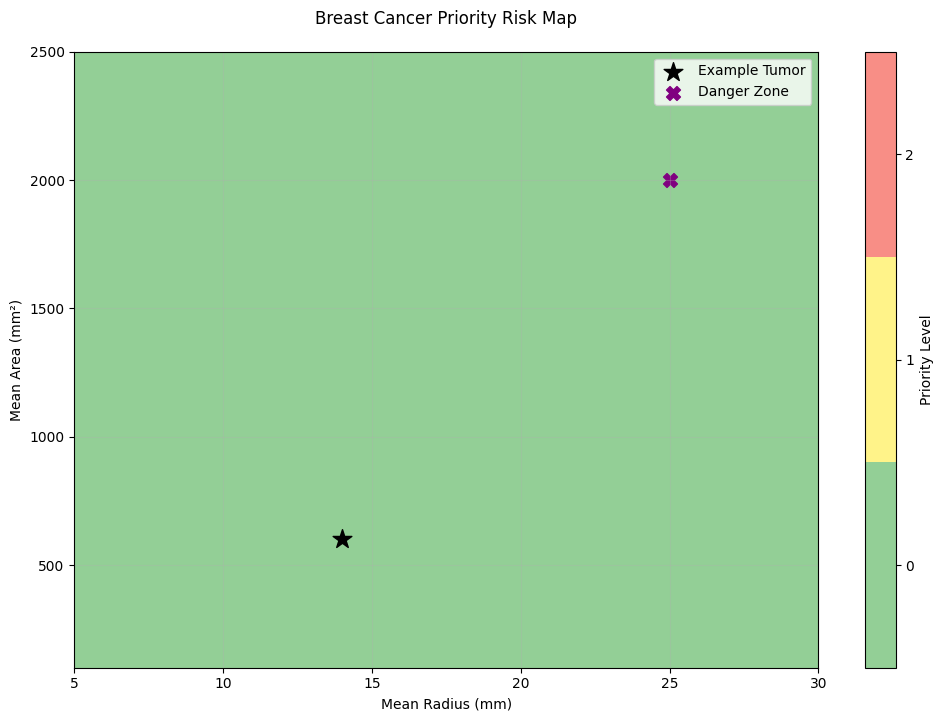

In [32]:
# Generate a grid of predictions
radius_range = np.linspace(5, 30, 50)
area_range = np.linspace(100, 2500, 50)
R, A = np.meshgrid(radius_range, area_range)
predictions = np.zeros_like(R)

for i in range(R.shape[0]):
    for j in range(R.shape[1]):
        sample = [[R[i,j], 19, 0, A[i,j], 0]]  # Fix texture at median value
        predictions[i,j] = model.predict(scaler.transform(sample))[0]

# Plot
plt.figure(figsize=(12,8))
contour = plt.contourf(R, A, predictions, levels=[-0.5, 0.5, 1.5, 2.5],
                      colors=['#4CAF50', '#FFEB3B', '#F44336'], alpha=0.6)
plt.colorbar(contour, ticks=[0,1,2], label='Priority Level')

# Add sample points
plt.scatter(14, 600, c='black', s=200, marker='*', label='Example Tumor')
plt.scatter(25, 2000, c='purple', s=100, marker='X', label='Danger Zone')

plt.xlabel('Mean Radius (mm)')
plt.ylabel('Mean Area (mm²)')
plt.title('Breast Cancer Priority Risk Map', pad=20)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [33]:
# Cell 11: Simple Report Generator
from datetime import datetime

def generate_report(radius, texture, area):
    """Generates a clean breast cancer assessment report"""

    # Get prediction
    sample = [[radius, texture, 0, area, 0]]  # 0 for unused features
    sample_scaled = scaler.transform(sample)
    priority = model.predict(sample_scaled)[0]

    # Priority details
    priority_levels = {
        0: ("Low", "green"),
        1: ("Medium", "orange"),
        2: ("High", "red")
    }

    recommendations = {
        0: "Routine follow-up in 6 months",
        1: "Urgent diagnostic workup within 2 weeks",
        2: "Immediate surgical consultation (within 48 hours)"
    }

    # Generate report
    print("\n" + "="*60)
    print("BREAST CANCER PRIORITY REPORT".center(60))
    print("="*60)
    print(f"Date:       {datetime.now().strftime('%Y-%m-%d')}")
    print(f"Priority:   {priority_levels[priority][0]}")
    print("-"*60)
    print("TUMOR CHARACTERISTICS:")
    print(f"  - Radius: {radius:.1f} mm")
    print(f"  - Texture: {texture:.1f}")
    print(f"  - Area: {area:.1f} mm²")
    print("-"*60)
    print("RECOMMENDATION:")
    print(f"  {recommendations[priority]}")
    print("="*60 + "\n")

# Example usage
generate_report(18.5, 24.3, 1500)


               BREAST CANCER PRIORITY REPORT                
Date:       2025-06-28
Priority:   Low
------------------------------------------------------------
TUMOR CHARACTERISTICS:
  - Radius: 18.5 mm
  - Texture: 24.3
  - Area: 1500.0 mm²
------------------------------------------------------------
RECOMMENDATION:
  Routine follow-up in 6 months



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



In [27]:
# 3D Risk Plot (Interactive)
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Scatter3d(
        x=df_imputed['mean radius'],
        y=df_imputed['mean area'],
        z=df_imputed['mean texture'],
        mode='markers',
        marker=dict(
            size=5,
            color=df_imputed['priority'],
            colorscale=['green','yellow','red'],
            opacity=0.8
        )
    )
])

fig.update_layout(
    scene=dict(
        xaxis_title='Radius (mm)',
        yaxis_title='Area (mm²)',
        zaxis_title='Texture'
    ),
    title='3D Tumor Characteristics by Priority'
)
fig.show()